# Projeto 2
## Introdução a Data Science
### Alunos
Gabriel de Melo Evangelista (gme@cin.ufpe.br)

Maria Luísa Leandro de Lima (mlll@cin.ufpe.br)
### Tema: Powerlifting
https://openpowerlifting.gitlab.io/opl-csv/bulk-csv-docs.html

### Leitura dos dados limpos 

### Imports

In [63]:
import os
import sys
import mlflow
import logging
import warnings
import numpy as np
import pandas as pd
import mlflow.sklearn
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv('../powerlifting_clean.csv')

Como o peso do atleta é um atributo extremamente interessante de se analisar para efeitos de comparação com seus feitos de levantamento, iremos tentar prever tal peso baseado em outros atributos das competições. Logo, para a classificação, a coluna BodyweightKg_dist será definida como categórica e será nossa label.

In [3]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
        df[str(col + "C")] = df[col].cat.codes

In [4]:
df.dtypes

Name                  category
Sex                      int64
Event                 category
Equipment             category
Division              category
BodyweightKg           float64
WeightClassKg         category
Best3SquatKg           float64
Best3BenchKg           float64
Best3DeadliftKg        float64
TotalKg                float64
Place                    int64
Dots                   float64
Wilks                  float64
Glossbrenner           float64
Goodlift               float64
EquipmentC                int8
DivisionC                int16
WeightClassKgC           int16
PlaceC                   int64
NameC                    int32
Age                    float64
Age_log                float64
BodyweightKg_log       float64
total_bodyweight       float64
BodyweightKg_dist     category
Age_dist              category
EventC                    int8
BodyweightKg_distC        int8
Age_distC                 int8
dtype: object

### 1. Escolha da Coluna

Como expresso no outro notebook, a coluna BodyweightKg_dist será utilizada para classificação. 

As colunas Dots, Glossbrenner, Wilks e Goodlift não serão usadas pois em seus cálculos o peso corporal do atleta é usado.

In [5]:
df.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Division', 'BodyweightKg',
       'WeightClassKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg',
       'TotalKg', 'Place', 'Dots', 'Wilks', 'Glossbrenner', 'Goodlift',
       'EquipmentC', 'DivisionC', 'WeightClassKgC', 'PlaceC', 'NameC', 'Age',
       'Age_log', 'BodyweightKg_log', 'total_bodyweight', 'BodyweightKg_dist',
       'Age_dist', 'EventC', 'BodyweightKg_distC', 'Age_distC'],
      dtype='object')

In [6]:
df.describe()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,...,WeightClassKgC,PlaceC,NameC,Age,Age_log,BodyweightKg_log,total_bodyweight,EventC,BodyweightKg_distC,Age_distC
count,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,...,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.0,568810.000000,568810.000000
mean,0.723514,82.072621,175.282608,113.651458,196.450341,485.383884,3.448582,359.527521,357.927874,336.611051,...,77.682771,28.012354,101043.531118,28.268291,1.418747,1.900668,5.961761,0.0,1.999156,2.056813
std,0.447268,20.687036,50.785754,39.608544,49.093086,132.870017,4.738064,47.998261,47.836152,48.492746,...,43.955096,29.547787,57436.637244,11.754245,0.163417,0.108533,1.102719,0.0,1.413738,1.418770
min,0.000000,38.050000,15.880000,20.000000,20.410000,178.000000,1.000000,248.600000,247.220000,236.230000,...,0.000000,0.000000,0.000000,8.500000,0.929419,1.580355,2.341295,0.0,0.000000,0.000000
25%,0.000000,66.500000,135.000000,80.000000,155.000000,375.000000,1.000000,322.150000,320.712500,299.060000,...,38.000000,0.000000,51785.000000,19.500000,1.290035,1.822822,5.154424,0.0,1.000000,1.000000
50%,1.000000,80.900000,175.000000,115.000000,200.000000,492.500000,2.000000,359.430000,357.750000,336.770000,...,86.000000,32.000000,101380.000000,24.500000,1.389166,1.907949,5.954825,0.0,2.000000,2.000000
75%,1.000000,94.200000,210.000000,142.500000,235.000000,587.500000,4.000000,396.940000,395.150000,374.100000,...,117.000000,43.000000,150602.750000,34.000000,1.531479,1.974051,6.749156,0.0,3.000000,3.000000
max,2.000000,163.900000,367.500000,260.820000,380.000000,850.000000,120.000000,473.270000,469.220000,455.670000,...,143.000000,119.000000,201539.000000,78.000000,1.892095,2.214579,9.082308,0.0,4.000000,4.000000


In [7]:
data = df[['Sex', 'Dots', 'DivisionC', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'PlaceC', 'Age','BodyweightKg']]

In [35]:
X = df[['Sex', 'BodyweightKg', 'Best3BenchKg', 'Best3DeadliftKg', 'PlaceC', 'Age', 'EquipmentC', 'DivisionC']]
y = df['Best3SquatKg']

In [36]:
y

0          80.0
1         105.0
2         137.5
3         232.5
4          80.0
          ...  
568805    162.5
568806    190.0
568807    180.0
568808    185.0
568809    220.0
Name: Best3SquatKg, Length: 568810, dtype: float64

In [37]:
X.dtypes

Sex                  int64
BodyweightKg       float64
Best3BenchKg       float64
Best3DeadliftKg    float64
PlaceC               int64
Age                float64
EquipmentC            int8
DivisionC            int16
dtype: object

As features utilizadas são colocadas na matriz X enquanto que a coluna a ser prevista é colocada no y.

### 2. Entendimento dos dados

In [176]:
from sklearn.decomposition import PCA
import sklearn
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
# data = PCA(n_components = 2).fit_transform(X_scaled)

In [177]:
def viz(viz_tecnique, params, data, scaler):
    reducer = None
    scale = scaler()
    X_scaled = scale.fit_transform(data.drop('BodyweightKg_dist', axis = 1))
    if viz_tecnique == sklearn.decomposition.PCA:
        reducer = viz_tecnique(n_components = 2)
    elif viz_tecnique == umap.UMAP:
        reducer = viz_tecnique(**params)
    data_reduced = reducer.fit_transform(X_scaled)

    color_label = {'(38.049, 64.09]': 'blue', '(64.09, 74.1]': 'red', '(99.1, 163.9]': 'green', '(84.9, 99.1]': 'magenta', '(74.1, 84.9]': 'yellow'}

    label_color = [color_label[x] for x in data['BodyweightKg_dist']]

    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=label_color)
    team_patches = [mpatches.Patch(color=color, label=team) for team, color in color_label.items()]
    plt.legend(handles=team_patches, loc='upper right')
    plt.show()

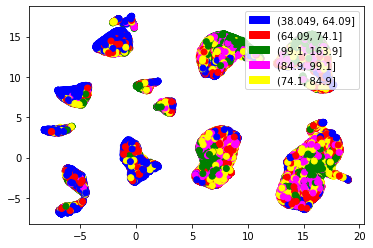

In [18]:
viz(umap.UMAP, {'n_neighbors':50}, data.sample(frac=0.1), MinMaxScaler)

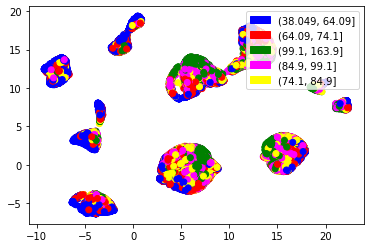

In [34]:
viz(umap.UMAP, {'n_neighbors':100}, data.sample(frac=0.1), MinMaxScaler)

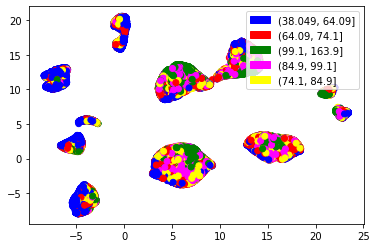

In [35]:
viz(umap.UMAP, {'n_neighbors':150}, data.sample(frac=0.1), MinMaxScaler)

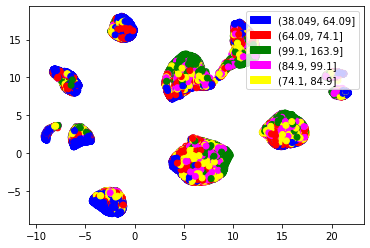

In [36]:
viz(umap.UMAP, {'n_neighbors':100, 'metric': 'manhattan'}, data.sample(frac=0.1), MinMaxScaler)

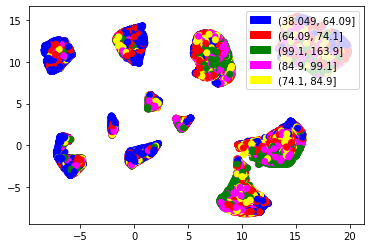

In [37]:
viz(umap.UMAP, {'n_neighbors':100, 'metric': 'cosine'}, data.sample(frac=0.1), MinMaxScaler)

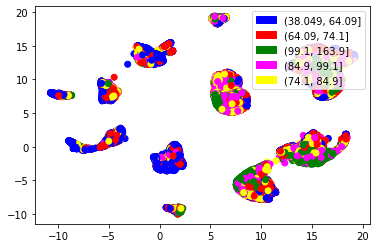

In [38]:
viz(umap.UMAP, {'n_neighbors':100, 'metric': 'chebyshev'}, data.sample(frac=0.1), MinMaxScaler)

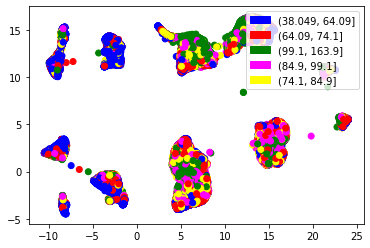

In [39]:
viz(umap.UMAP, {'n_neighbors':200, 'metric': 'chebyshev'}, data.sample(frac=0.1), MinMaxScaler)

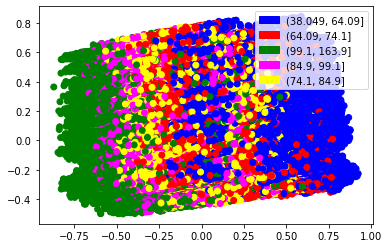

In [19]:
viz(PCA, {},data, MinMaxScaler)

In [20]:
data.shape

(568810, 9)

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# scale = MinMaxScaler()
# X_scaled = scale.fit_transform(data.drop('Bodyweight_dist', axis = 1))
kmeans = KMeans(n_clusters=5)
kmeans.fit(data.drop('BodyweightKg_dist', axis = 1))

KMeans(n_clusters=5)

<Figure size 720x504 with 0 Axes>

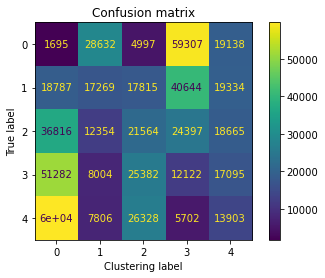

InvalidIndexError: (slice(None, None, None), 0)

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y, kmeans.labels_)

plt.figure(figsize = (10,7))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Clustering label')
plt.show()

plt.scatter(data.drop('BodyweightKg_dist', axis = 1)[:, 0], data.drop('BodyweightKg_dist', axis = 1)[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.7)


### 3. Separação dos dados

Para realizar a separação dos dados será utilizada a função "train_test_split" do sklearn.

Os dados serão separados em 50% para treino, 25% para validação e 25% para teste. Para isso, será utilizada a função 2 vezes como observado abaixo.

In [23]:
X_train, x_f, y_train, y_f = train_test_split(X, y, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(x_f, y_f, test_size = 0.5)

In [24]:
X.shape

(568810, 8)

In [25]:
X_train.shape

(284405, 8)

In [26]:
X_val.shape

(142202, 8)

In [27]:
X_test.shape

(142203, 8)

Percebe-se pelos prints acima que a divisão funcionou da forma esperada.

### 4. Seleção dos algoritmos

In [28]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [73]:
def train(model, X_train, y_train, X_val, y_val, X_test, y_test, params={}):
    logging.basicConfig(level=logging.WARN)
    logger = logging.getLogger(__name__)

    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

    warnings.filterwarnings("ignore")
    np.random.seed(40)

    with mlflow.start_run():
        lr = model(**params)
        lr.fit(X_train, y_train)

        # Evaluate Metrics
        predicted_qualities = lr.predict(X_val)
        (rmse, mae, r2) = eval_metrics(y_val, predicted_qualities)

        print(params)
        # Print out metrics
        print(str(model)+" model " + str(params))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)
        b = pd.DataFrame({'True':y_val, 'Pred':predicted_qualities}).sort_values(by='True').reset_index()
        fig, ax = plt.subplots(1, 2, figsize=(30,10))
        ax[0].plot(b['True'])
        ax[1].plot(b['Pred'])
        plt.show()
        # Log parameter, metrics, and model to MLflow
        if params == {}:
            params = model().get_params()
        mlflow.log_params(params)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        #mlflow.sklearn.log_model(lr, "model")

{}
<class 'sklearn.linear_model._base.LinearRegression'> model {}
  RMSE: 19.73515272736439
  MAE: 14.908527584933257
  R2: 0.8384061455120875


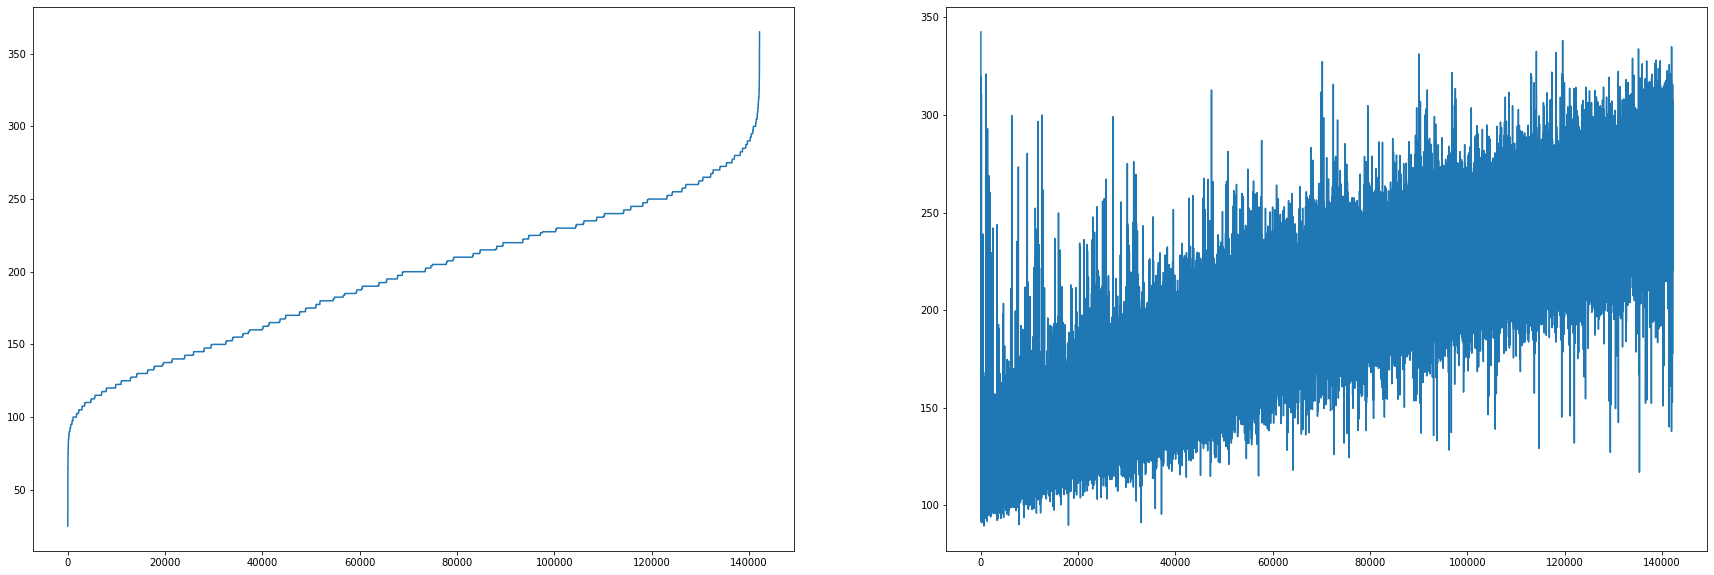

In [74]:
train(LinearRegression, X_train, y_train, X_val, y_val, X_test, y_test)

{}
<class 'sklearn.linear_model._ridge.Ridge'> model {}
  RMSE: 19.735151659628322
  MAE: 14.908522092246901
  R2: 0.8384061629975952


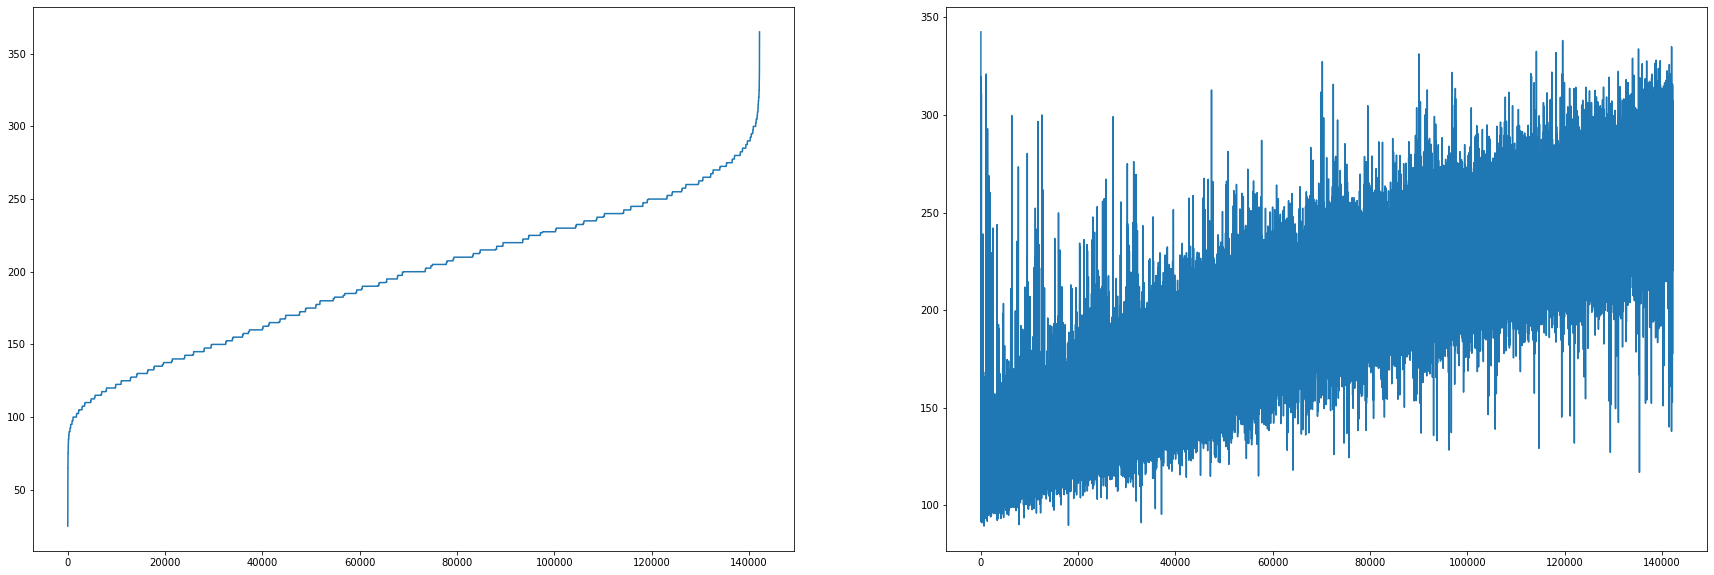

In [75]:
train(Ridge, X_train, y_train, X_val, y_val, X_test, y_test)

{}
<class 'sklearn.tree._classes.DecisionTreeRegressor'> model {}
  RMSE: 25.55366476469046
  MAE: 19.066923777443353
  R2: 0.7290742757702146


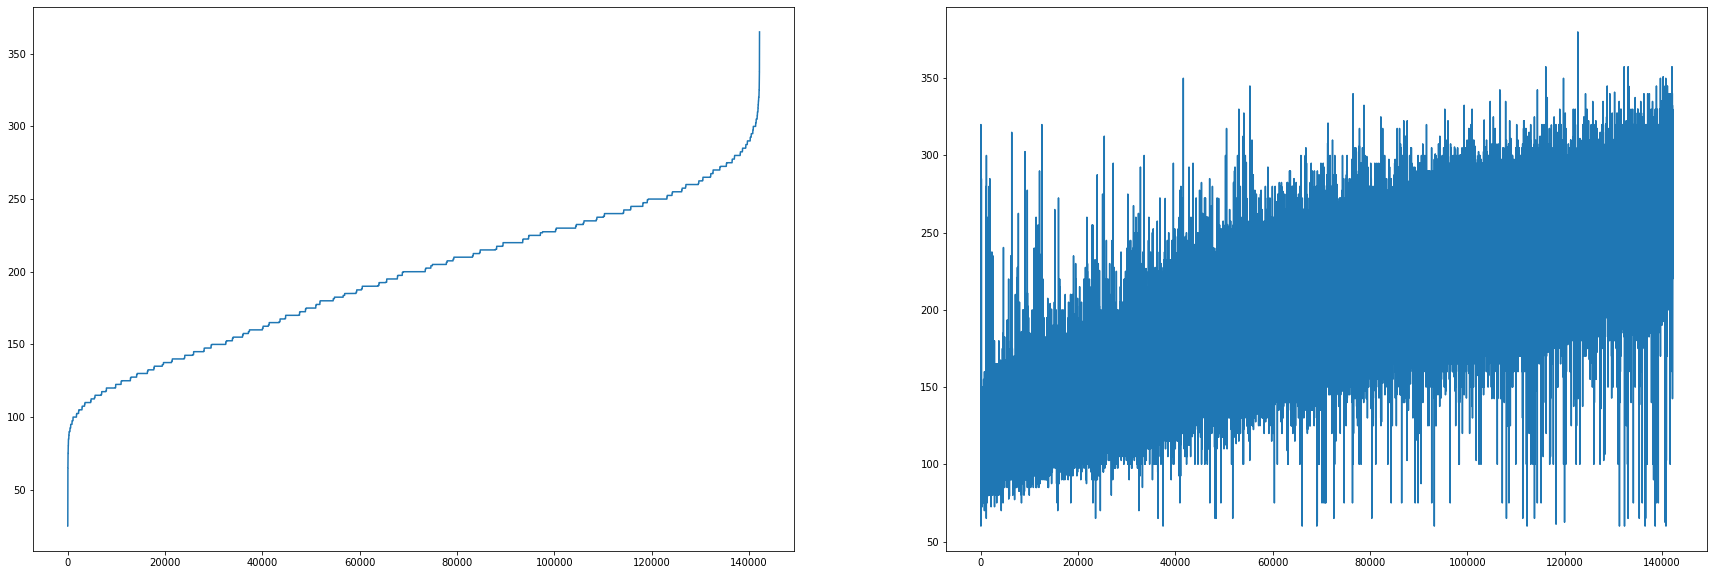

In [76]:
train(DecisionTreeRegressor, X_train, y_train, X_val, y_val, X_test, y_test)

{}
<class 'sklearn.neighbors._regression.KNeighborsRegressor'> model {}
  RMSE: 20.52051808386849
  MAE: 15.59969731789989
  R2: 0.8252888994628201


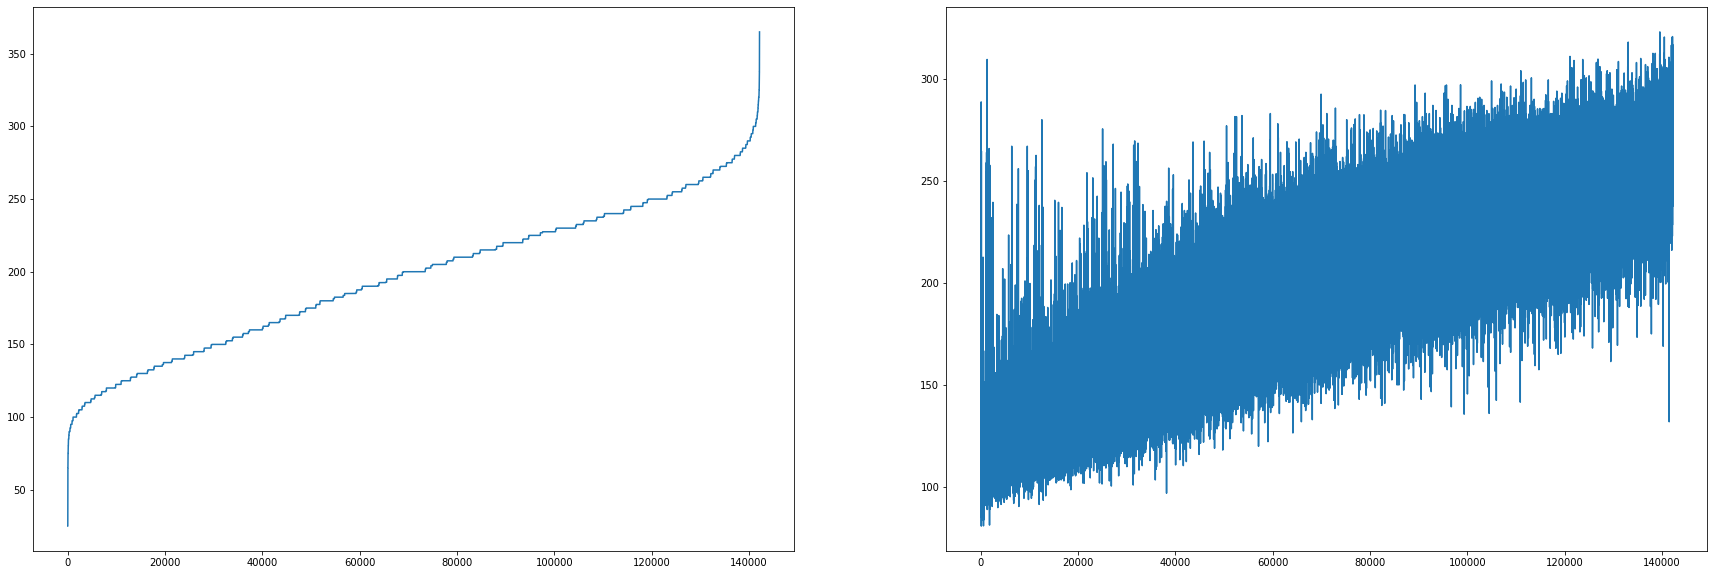

In [77]:
train(KNeighborsRegressor, X_train, y_train, X_val, y_val, X_test, y_test)

{}
<class 'xgboost.sklearn.XGBRegressor'> model {}
  RMSE: 18.090777726804365
  MAE: 13.709096113190924
  R2: 0.8642129565721459


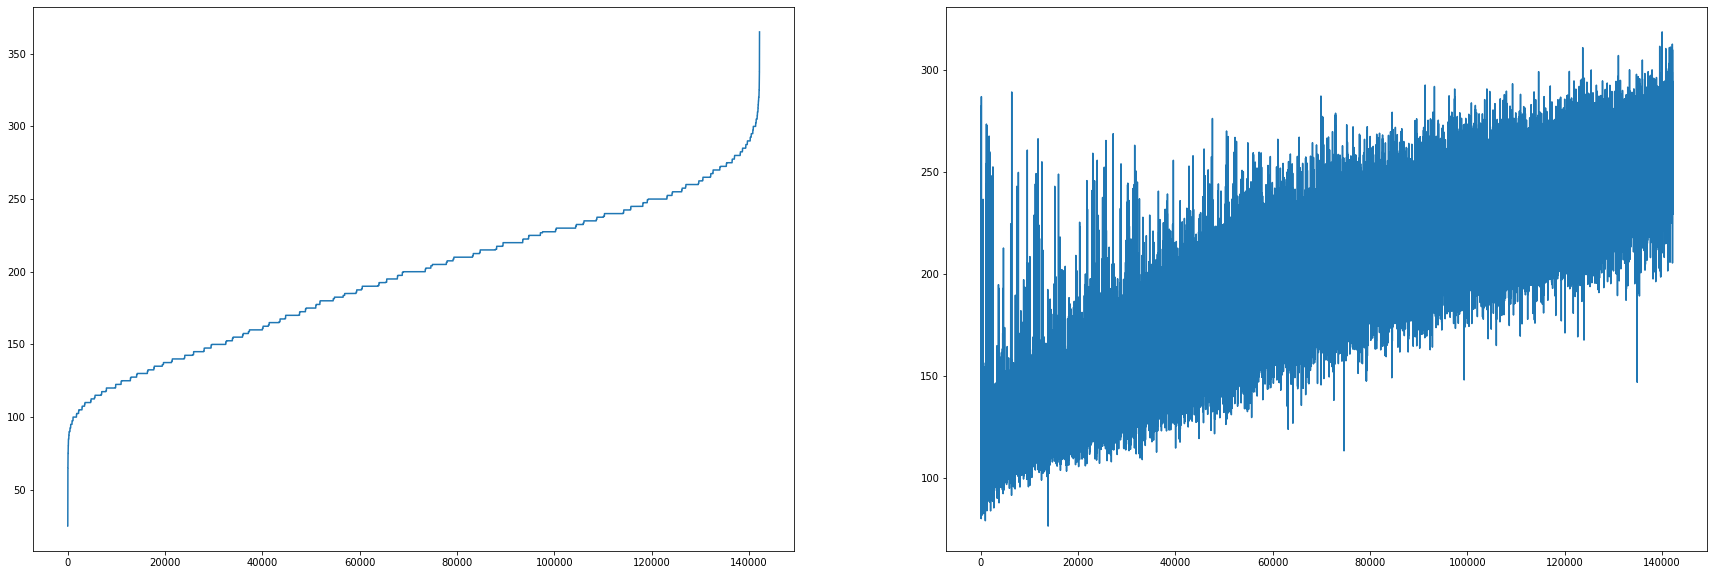

In [78]:
train(XGBRegressor, X_train, y_train, X_val, y_val, X_test, y_test)

In [79]:
train(RandomForestRegressor, X_train, y_train, X_val, y_val, X_test, y_test)

23.39729256958037


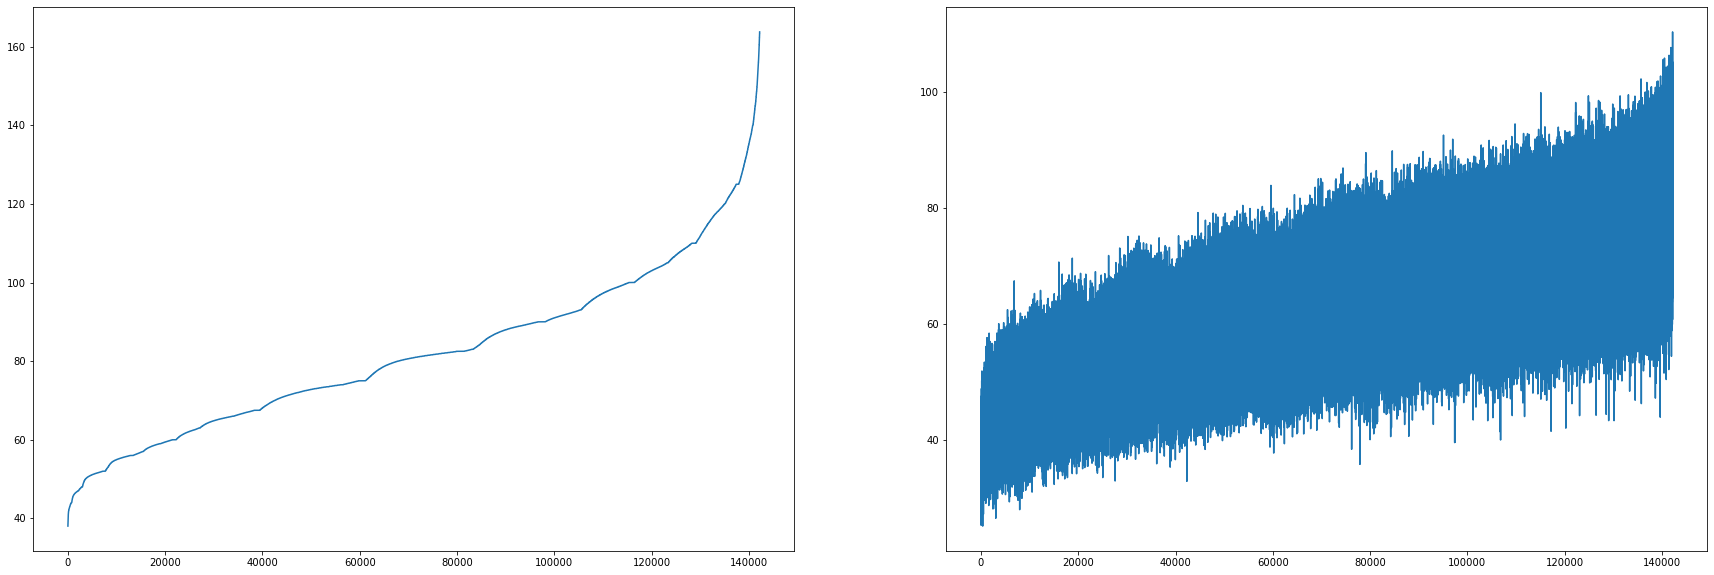

In [306]:
train(LinearSVR, X_train, y_train, X_val, y_val, X_test, y_test)

In [192]:
data.describe()

,Sex,Dots,DivisionC,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,PlaceC,Age,BodyweightKg
count,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000
mean,0.723514,359.527521,1057.226093,175.282608,113.651458,196.450341,485.383884,28.012354,28.268291,82.072621
std,0.447268,47.998261,442.132516,50.785754,39.608544,49.093086,132.870017,29.547787,11.754245,20.687036
min,0.000000,248.600000,0.000000,15.880000,20.000000,20.410000,178.000000,0.000000,8.500000,38.050000
25%,0.000000,322.150000,627.000000,135.000000,80.000000,155.000000,375.000000,0.000000,19.500000,66.500000
50%,1.000000,359.430000,1311.000000,175.000000,115.000000,200.000000,492.500000,32.000000,24.500000,80.900000
75%,1.000000,396.940000,1386.000000,210.000000,142.500000,235.000000,587.500000,43.000000,34.000000,94.200000
max,2.000000,473.270000,1785.000000,367.500000,260.820000,380.000000,850.000000,119.000000,78.000000,163.900000


### MLFlow test

{'alpha': 0.6}
<class 'sklearn.linear_model._ridge.Ridge'> model {'alpha': 0.6}
  RMSE: 19.735152086259408
  MAE: 14.908524286978011
  R2: 0.8384061560109801


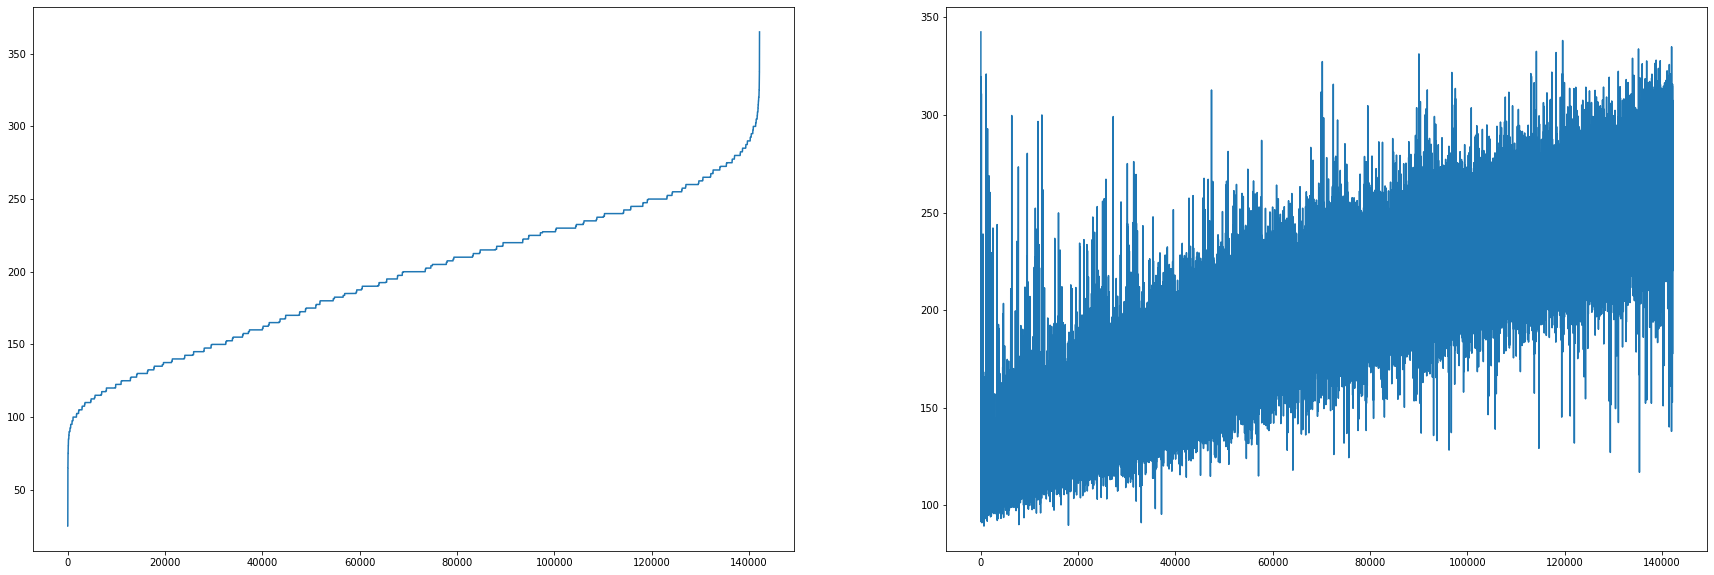

In [62]:
train(Ridge, X_train, y_train, X_val, y_val, X_test, y_test, params={"alpha": 0.6})

Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 13.670594687069057
  MAE: 10.36417910435138
  R2: 0.563940139141448


In [68]:
train(0.4, 0.6)

Elasticnet model (alpha=0.400000, l1_ratio=0.600000):
  RMSE: 0.9241943189581605
  MAE: 0.7384616608162445
  R2: 0.5728755811989574


In [69]:
train(0.1, 0.2)

Elasticnet model (alpha=0.100000, l1_ratio=0.200000):
  RMSE: 0.9221311546100779
  MAE: 0.7363921989568428
  R2: 0.5747804711811142
